## Credit Card Churn Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pointbiserialr
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("credit_card.xlsx")
df['Churn'] = df['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)
df = df.sort_values(['CLIENTNUM', 'Year']).drop_duplicates('CLIENTNUM', keep='last')
df.drop(columns=['Avg_Open_To_Buy', 'Date_Leave', 'Quarter'], inplace=True)
cat_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))
df.dropna(inplace=True)

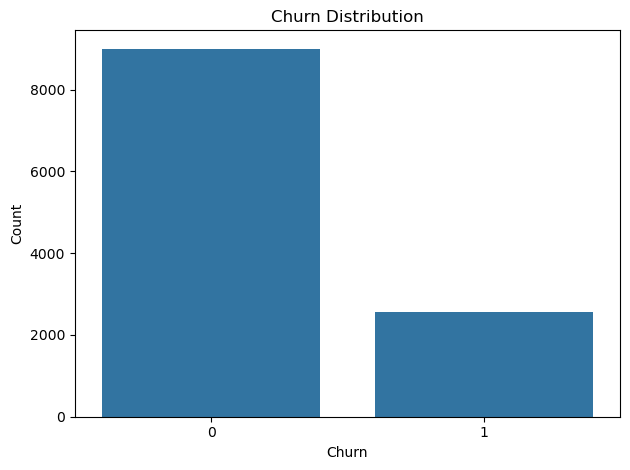

In [3]:
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

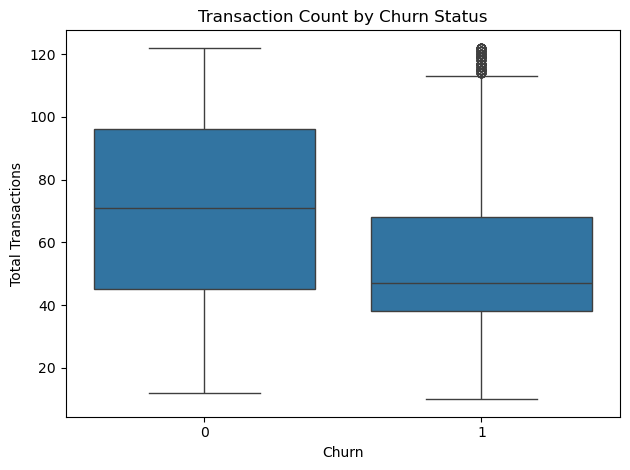

In [4]:
sns.boxplot(x='Churn', y='Total_Trans_Ct', data=df)
plt.title('Transaction Count by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Total Transactions')
plt.tight_layout()
plt.show()

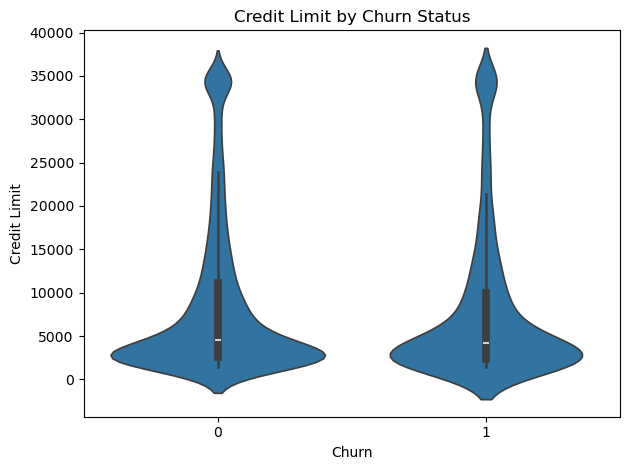

In [5]:
sns.violinplot(x='Churn', y='Credit_Limit', data=df)
plt.title('Credit Limit by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Credit Limit')
plt.tight_layout()
plt.show()

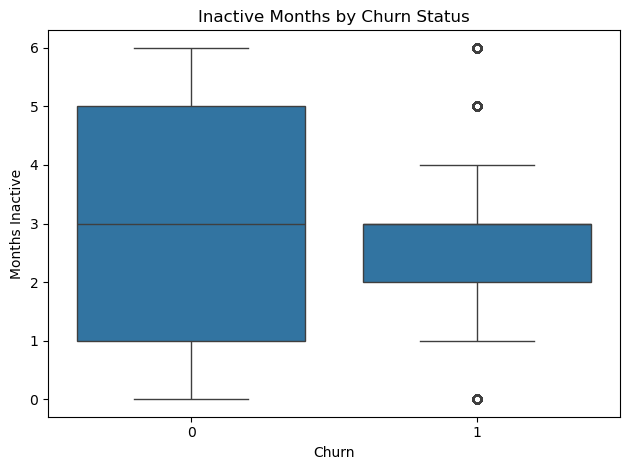

In [6]:
sns.boxplot(x='Churn', y='Months_Inactive_12_mon', data=df)
plt.title('Inactive Months by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Months Inactive')
plt.tight_layout()
plt.show()

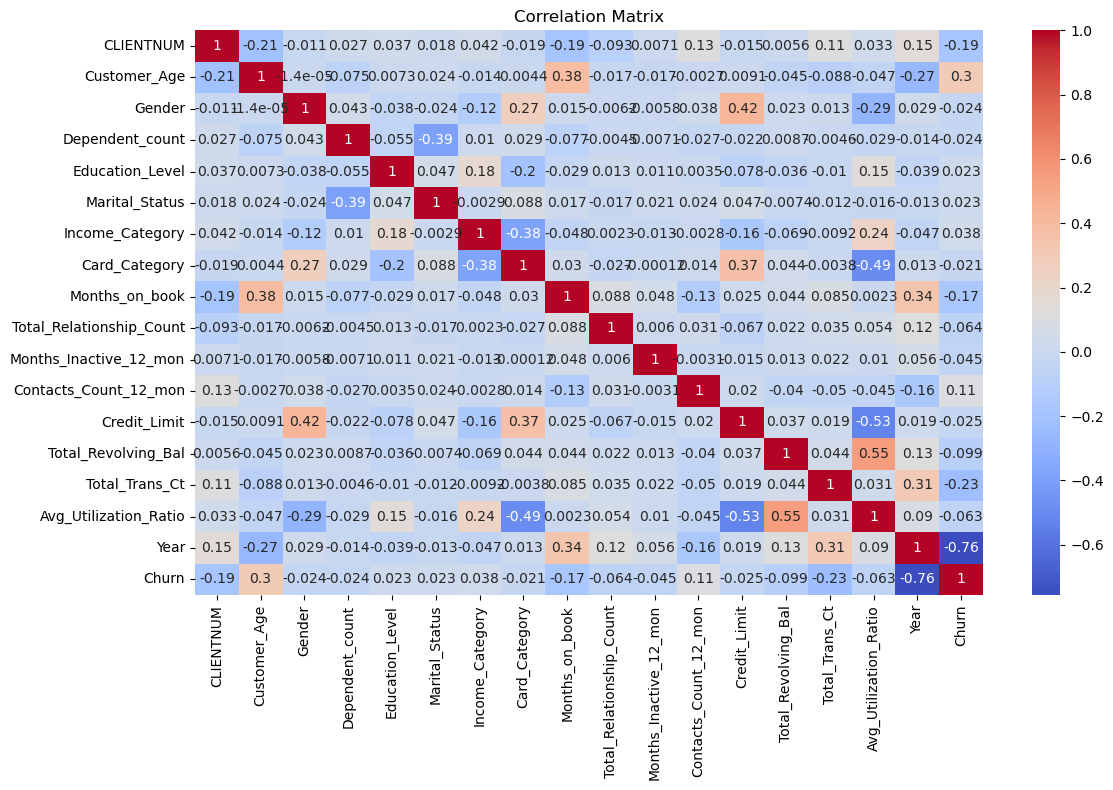

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [8]:
from scipy.stats import ttest_ind

churned = df[df['Churn'] == 1]['Credit_Limit']
retained = df[df['Churn'] == 0]['Credit_Limit']

t1, p1 = ttest_ind(churned, retained, equal_var=False)
print(f"H1 - Credit Limit t-test: t = {t1:.2f}, p = {p1:.5f}")

H1 - Credit Limit t-test: t = -2.72, p = 0.00650


In [9]:
from scipy.stats import pointbiserialr

r2, p2 = pointbiserialr(df['Churn'], df['Total_Trans_Ct'])
print(f"H2 - Point-Biserial Correlation: r = {r2:.2f}, p = {p2:.5f}")

H2 - Point-Biserial Correlation: r = -0.23, p = 0.00000


In [10]:
t3, p3 = ttest_ind(df[df['Churn'] == 1]['Months_Inactive_12_mon'],
                   df[df['Churn'] == 0]['Months_Inactive_12_mon'], equal_var=False)
print(f"H3 - Inactivity t-test: t = {t3:.2f}, p = {p3:.5f}")

H3 - Inactivity t-test: t = -5.93, p = 0.00000


In [11]:
from scipy.stats import chi2_contingency
import pandas as pd

edu_table = pd.crosstab(df['Education_Level'], df['Churn'])
chi2, p4, dof, expected = chi2_contingency(edu_table)
print(f"H4 - Chi-Square Test: χ² = {chi2:.2f}, p = {p4:.5f}, df = {dof}")

H4 - Chi-Square Test: χ² = 12.43, p = 0.02940, df = 5


In [12]:
from scipy.stats import f_oneway

groups = df.groupby('Income_Category')['Credit_Limit'].apply(list)
f5, p5 = f_oneway(*groups)
print(f"H5 - ANOVA Income vs Credit_Limit: F = {f5:.2f}, p = {p5:.5f}")

H5 - ANOVA Income vs Credit_Limit: F = 12530.92, p = 0.00000


In [13]:
from scipy.stats import f_oneway

combo_groups = df.groupby(['Gender', 'Card_Category'])['Avg_Utilization_Ratio'].apply(list)
valid_groups = [g for g in combo_groups if len(g) > 1]
f6, p6 = f_oneway(*valid_groups)
print(f"H6 - Two-Way ANOVA Gender×Card: F = {f6:.2f}, p = {p6:.5f}")

H6 - Two-Way ANOVA Gender×Card: F = 1036.97, p = 0.00000


In [14]:
from scipy.stats import mannwhitneyu

churned_trans = df[df['Churn'] == 1]['Total_Trans_Ct']
retained_trans = df[df['Churn'] == 0]['Total_Trans_Ct']
u7, p7 = mannwhitneyu(churned_trans, retained_trans, alternative='two-sided')
print(f"H7 - Mann-Whitney U Test: U = {u7:.0f}, p = {p7:.5e}")

H7 - Mann-Whitney U Test: U = 7845196, p = 2.05694e-137


In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder

# Encode Card_Category to numeric
df['Card_Category_Label'] = LabelEncoder().fit_transform(df['Card_Category'].astype(str))

# Fit the multinomial logistic regression model
model = smf.mnlogit("Card_Category_Label ~ Credit_Limit + Avg_Utilization_Ratio + Months_Inactive_12_mon", data=df)
result = model.fit(disp=0)

print("H8 - Multinomial Logistic Regression:")
print(result.pvalues)


H8 - Multinomial Logistic Regression:
                                   0              1              2
Intercept               5.157151e-46   2.772400e-78  2.469574e-115
Credit_Limit            4.616624e-93  1.667407e-114  9.666542e-122
Avg_Utilization_Ratio   1.279469e-02   1.900322e-01   2.562306e-01
Months_Inactive_12_mon  7.628721e-01   6.990489e-01   8.426323e-01


In [18]:
X = df.drop(columns=['Attrition_Flag', 'CLIENTNUM', 'Churn', 'Year'])
X = pd.get_dummies(X)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
print("Logistic Regression")
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      2700
           1       0.72      0.35      0.47       772

    accuracy                           0.83      3472
   macro avg       0.78      0.66      0.68      3472
weighted avg       0.81      0.83      0.80      3472

Accuracy: 0.8257488479262672


In [20]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print("Decision Tree")
print(classification_report(y_test, y_pred_tree))
print("Accuracy:", accuracy_score(y_test, y_pred_tree))

Decision Tree
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2700
           1       1.00      0.50      0.66       772

    accuracy                           0.89      3472
   macro avg       0.94      0.75      0.80      3472
weighted avg       0.90      0.89      0.87      3472

Accuracy: 0.8882488479262672


In [21]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
y_pred_rf = forest.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2700
           1       0.98      0.55      0.71       772

    accuracy                           0.90      3472
   macro avg       0.93      0.78      0.82      3472
weighted avg       0.91      0.90      0.89      3472

Accuracy: 0.8986175115207373


In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(forest, X, y, cv=cv, scoring='accuracy')
print("Random Forest CV Accuracy:", cv_score.mean())

Random Forest CV Accuracy: 0.9003544207388214


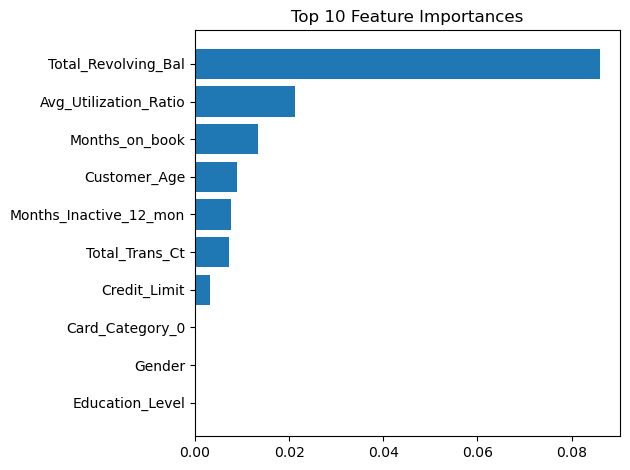

In [23]:
perm = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)
idx = perm.importances_mean.argsort()[-10:]
plt.barh(np.array(X.columns)[idx], perm.importances_mean[idx])
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

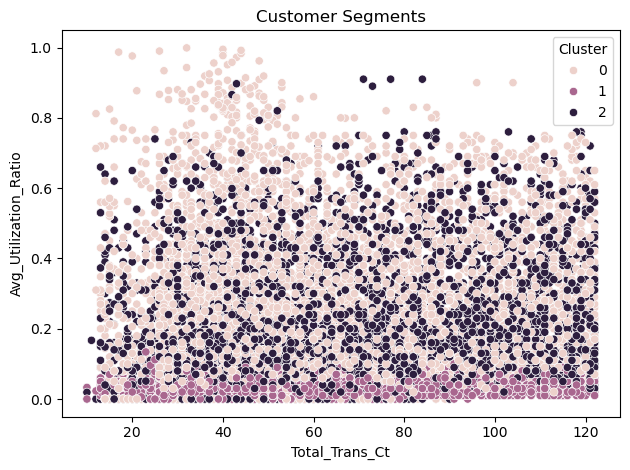

In [24]:
cluster_vars = ['Total_Trans_Ct', 'Credit_Limit', 'Months_Inactive_12_mon', 'Avg_Utilization_Ratio']
X_cluster = StandardScaler().fit_transform(df[cluster_vars])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_cluster)
df['Cluster'] = kmeans.labels_

sns.scatterplot(x='Total_Trans_Ct', y='Avg_Utilization_Ratio', hue='Cluster', data=df)
plt.title("Customer Segments")
plt.tight_layout()
plt.show()